# Triangular profile façade [Section VI.A]
This notebook runs the necessary simulations and plots the energy time decays resulting from a façade with a triangular pattern cross-section.

In this example, the models for the corresponding Bidirectional Reflectance Distribution Functions (BRDF) are loaded from local ``.sofa`` files.

*Check example [``App_BRDF_generation.ipynb``](App_BRDF_generation.ipynb) to generate the BRDF files from their corresponding scattering models.*

![alt text](figures/tri_facade.svg "Illustration of the triangular profile façade")

In [1]:
import sparrowpy as sp
import numpy as np
import os
import pyfar as pf
import matplotlib.pyplot as plt
import pyrato
from utils.fig_formatting import create_fig, export_fig

%matplotlib inline

basepath=os.path.join(os.getcwd())
plot_path = os.path.join(basepath, 'figures')

Select data origin (same as paper or user-generated)

In [2]:
###################################################
#### SET "True" TO LOAD YOUR OWN GENERATED DATA
#### "False" TO LOAD THE DATA FROM THE PAPER
self_data=False
###################################################

if self_data:
    sub_dir="user"
else:
    sub_dir="paper"


Setup simulation

In [3]:
# façade dimensions
height = 9
width = 19

# S-R positions
source = pf.Coordinates(10+width/2, 10, 1.5)
receiver = pf.Coordinates(11+width/2, 11, 1.5)

# simulation parameters
patch_size = .25
sampling_rate = 1000
speed_of_sound = 343.2
etc_time = .5  # seconds

Load BRDF

In [4]:
# BRDF from simulated BSC data
brdf_new, directions_bsc, directions_bsc = pf.io.read_sofa(
    os.path.join(basepath, 'resources', sub_dir, 'brdf_walls_BSC.sofa'))

# BRDF from RISC model
brdf_rand, directions_bsc, directions_bsc = pf.io.read_sofa(
    os.path.join(basepath, 'resources', sub_dir, 'brdf_walls_RISC.sofa'))

SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights
SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights


Run sparrowpy simulations

In [5]:
etcs = []
brdfs = [brdf_new, brdf_new, brdf_rand]
for i_brdf in range(len(brdfs)):
    brdf = brdfs[i_brdf]
    if i_brdf == 0:
        # vertical surface pattern orientation
        up_vector_wall = [1, 0, 0]
    else:
        # horizontal surface pattern orientation
        up_vector_wall = [0, 0, 1]

    plane = sp.geometry.Polygon(
            [[0, 0, 0],
            [width, 0, 0],
            [width, 0, height],
            [0, 0, height]],
            up_vector_wall, [0, 1, 0])

    #simulation parameters
    radi = sp.DirectionalRadiosityFast.from_polygon(
        [plane], patch_size)


    radi.set_wall_brdf(
        np.arange(1), brdf, directions_bsc, directions_bsc)

    # set air absorption
    radi.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # initialize source energy at each patch
    radi.init_source_energy(source)

    # # gather energy at receiver
    radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=1/sampling_rate,
        etc_duration=etc_time,
        max_reflection_order=0)

    direct_sound, _ = radi.calculate_direct_sound(receiver)

    etc = radi.collect_energy_receiver_mono(receiver, True)
    etcs.append(etc)

etc_BSC_vertical = etcs[0]
etc_BSC_horizontal = etcs[1]
etc_RISC = etcs[2]


C:\Users\jotag\AppData\Local\Temp\ipykernel_23516\3451534380.py:24: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radi.set_wall_brdf(


Load RAVEN (ray-tracing) reference ETC

In [6]:
raven = np.loadtxt(
    os.path.join(basepath,'resources','paper','raven_facade.csv'),
    delimiter="," )
raven = pf.TimeData(
    raven[1:, 3:-2].T,
    raven[1:, 0],
)
frequencies_nom, frequencies_out = pf.dsp.filter.fractional_octave_frequencies(
    1, (np.min(brdf.frequencies)/1.1, np.max(brdf.frequencies)*1.1),
)


Plot energy time/decay curves resulting from the simulations

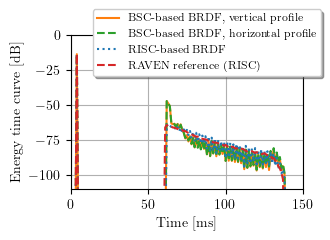

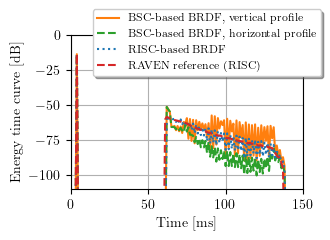

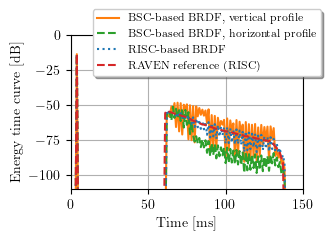

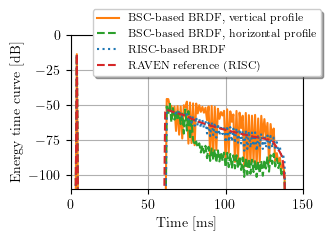

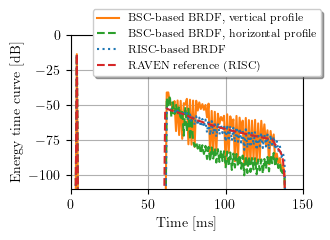

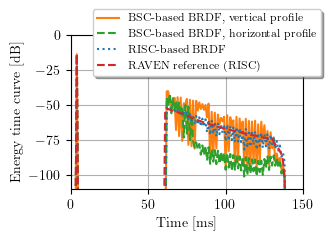

In [7]:
# set "True" for Schoeder curve, "False" for ETC
is_decay= False

for i_band in range(brdf.n_bins):

    i_receiver = 0
    energy_direct_db = 10*np.log10(direct_sound/1e-12)

    all_etcs =  pf.utils.concatenate_channels([
            etc_BSC_vertical[i_receiver, i_band],
            etc_BSC_horizontal[i_receiver, i_band],
            etc_RISC[i_receiver, i_band],
            raven[i_band]/(4*np.pi),
        ])
    if is_decay:
        edcs = pyrato.edc.schroeder_integration(all_etcs, True)
    else:
        edcs = all_etcs
    fig, ax = create_fig(figtype="stubby")
    ax = pf.plot.time(
        edcs[0],
        dB=True, log_prefix=10, unit='ms', log_reference=1,
        label='BSC-based BRDF, vertical profile',
        color='C1',
    )
    ax = pf.plot.time(
        edcs[1],
        dB=True, log_prefix=10, unit='ms', log_reference=1,
        label='BSC-based BRDF, horizontal profile',
        color='C2',
        linestyle='--',
    )
    ax = pf.plot.time(
        edcs[2],
        dB=True, log_prefix=10, unit='ms', log_reference=1,
        label='RISC-based BRDF',
        color='C0',
        linestyle=':',
    )
    ax = pf.plot.time(
        edcs[3],
        dB=True, log_prefix=10, unit='ms', log_reference=1,
        label='RAVEN reference (RISC)',
        color='C3',
        linestyle='--',
    )

    ax.set_xlim((0, 150))
    ax.set_ylim([-150+40,-40+40])
    ax.set_xlabel("Time [ms]")

    if is_decay:
        ax.set_ylabel("Energy decay curve [dB]")
    else:
        ax.set_ylabel("Energy time curve [dB]")


    ff = frequencies_nom[i_band]
    frequency_str = f'{ff/1000:.0f}kHz' if ff >=1e3 else f'{ff:.0f}Hz'
    plt.legend(fontsize=8,loc="upper right",
               bbox_to_anchor=(1.1, 1.2),shadow=True)
    print()

    if ff == 125:
        export_fig(fig,'Figure10a')
    elif ff == 4e3:
        export_fig(fig,'Figure10b')

    ax.set_title(f'{frequency_str} octave band')
    plt.show()


